# Capstone Webscrapping using BeautifulSoup

This notebook contains guidances & tasks on the data processing for the application

## Background

Pada proyek ini kita akan men-scrapping data harga harian dolar amerika (USD) terhadap rupiah indonesia (IDR). Website yang kita scrapping adalah exchange-rates.org. 

Kita akan men-scrapping dua hal. Data tanggal beserta nilai USD terhadap IDR. Data diambil dari tanggal 11 Oktober 2021 sampai tanggal 9 April 2022. Kurang lebih enam bulan ke belakang.


## Requesting the Data and Creating a BeautifulSoup

Let's begin with requesting the web from the site with `get` method.

In [1]:
import requests

url_get = requests.get('https://www.exchange-rates.org/history/IDR/USD/T')

To visualize what exactly you get from the `request.get`, we can use .content so ee what we exactly get, in here i slice it so it won't make our screen full of the html we get from the page. You can delete the slicing if you want to see what we fully get.

In [2]:
url_get.content[1:500]

b'!DOCTYPE html>\r\n<!--[if lt IE 9]>\r\n<html class="no-js ie8 oldie" lang="en" xml:lang=\'en\'>\r\n<![endif]-->\r\n<!--[if gt IE 8]><!--><html class="no-js" lang="en" xml:lang=\'en\'><!--<![endif]-->\r\n<head>\r\n<title>Indonesian Rupiah Exchange Rate - US Dollar - Historical Exchange Rates</title>\r\n<meta http-equiv="X-UA-Compatible" content="IE=edge">\r\n<meta name="viewport" content="width=device-width, initial-scale=1, maximum-scale=5">\r\n<meta charset="utf-8" /><meta http-equiv="Content-Type" content="text/ht'

As we can see we get a very unstructured and complex html, which actually contains the codes needed to show the webpages on your web browser. But we as human still confused what and where we can use that piece of code, so here where we use the beautifulsoup. Beautiful soup class will result a beautifulsoup object. Beautiful Soup transforms a complex HTML document into a complex tree of Python objects. 

Let's make Beautiful soup object and feel free to explore the object here.

In [3]:
from bs4 import BeautifulSoup 

soup = BeautifulSoup(url_get.content,"html.parser")
print(soup.prettify()[:400])

<!DOCTYPE html>
<!--[if lt IE 9]>
<html class="no-js ie8 oldie" lang="en" xml:lang='en'>
<![endif]-->
<!--[if gt IE 8]><!-->
<html class="no-js" lang="en" xml:lang="en">
 <!--<![endif]-->
 <head>
  <title>
   Indonesian Rupiah Exchange Rate - US Dollar - Historical Exchange Rates
  </title>
  <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
  <meta content="width=device-width, initial-scal


## Finding the right key to scrap the data & Extracting the right information

Dari observasi dengan menggunakan developer tool 'inspect'. Data yang diperlukan terbungkus dengan menggunakan tag html ```<tbody>```. Tag tersebut merupakan 'anak' dari tag ```<table>```. Kita menggunakan fungsi **find()** dari beautifulsoup untuk mengekstrak datanya. 

Data yang tertangkap dengan fungsi **find()** mencakup keseluruhan tabel. Tabelnya memiliki 4 kolom. Pertama kolom tanggal; kedua kolom nama hari; ketiga kolom harga harian; keempat kolom keterangan tambahan. Data yang kita perlukan ada di kolom pertama, ketiga dan keempat. Data harga harian ada di  kolom ketiga. Data tanggal ada di dua kolom; baik pertama maupun keempat. Pilih yang mana ya?

Data tanggal akan kita ekstrak dari kolom keempat. Ini dilakukan karena pada kolom ketiga (data harga harian) dan kolom keempat (data tanggal) sama-sama terbungkus oleh tag html ```<a>```. Dengan demikian maka pekerjaan ektraksi kedua data dapat dilakukan sekali jalan dengan menggunakan fungsi findall(). 

In [4]:
table = soup.find('tbody')
print(table.prettify()[1:500])

tbody>
 <tr>
  <td>
   4/8/2022
  </td>
  <td>
   Friday
  </td>
  <td>
   <a href="/Rate/USD/IDR/4-8-2022">
    14,361.23753
   </a>
   IDR
  </td>
  <td class="text-narrow-screen-hidden">
   <a href="/Rate/USD/IDR/4-8-2022">
    USD IDR rate for 4/8/2022
   </a>
  </td>
 </tr>
 <tr>
  <td>
   4/7/2022
  </td>
  <td>
   Thursday
  </td>
  <td>
   <a href="/Rate/USD/IDR/4-7-2022">
    14,376.17757
   </a>
   IDR
  </td>
  <td class="text-narrow-screen-hidden">
   <a href="/Rate/USD/IDR/4-7-2022


In [5]:
ekstrak = table.find_all('a')
ekstrak[:6]

[<a href="/Rate/USD/IDR/4-8-2022">14,361.23753</a>,
 <a href="/Rate/USD/IDR/4-8-2022">USD IDR rate for 4/8/2022</a>,
 <a href="/Rate/USD/IDR/4-7-2022">14,376.17757</a>,
 <a href="/Rate/USD/IDR/4-7-2022">USD IDR rate for 4/7/2022</a>,
 <a href="/Rate/USD/IDR/4-6-2022">14,353.48743</a>,
 <a href="/Rate/USD/IDR/4-6-2022">USD IDR rate for 4/6/2022</a>]

Finding row length.

In [6]:
row_length = len(ekstrak)
row_length

260

Hasil ekstrak dengan menggunakan fungsi findall() masih 'kotor'. Ada bagian yang perlu dibuang dan ada bagian yang perlu diubah, yaitu: 
- Tag html ```<a>...</a>``` yang menjadi pembungkus akan dibuang
- Tanda baca **koma (,)** pada data harga harian akan kita ubah menjadi tanda baca **titik (.)**
- Text 'USD IDR rate for ' pada data tanggal akan dibuang

Jika diperhatikan secara seksama. List yang dipakai untuk menampung data hasil ekstrak memiliki pola. List-nya berselang-seling berisi data harga harian dan tanggal secara bergantian. Kalo kita menggunakan zero-based index maka index yang genap berisi data harga harian; index yang ganjil berisi data tanggal. Pola ini akan kita jadikan celah untuk memoles datanya lebih bersih lagi.

Kita akan menggunakan perulangan untuk iterasi di dalam  list. Iterasi dilakukan dari index  nol sampai dengan index terakhir sebanyak panjang list. Kita iterasi dengan panjang langkah (step) dua-dua. Untuk setiap iterasi kita tangkap **data harga** dan **data tanggal** dengan menggunakan attribut ```text```. Lebih detilnya pada data harga kita juga melakukan mengubah **tanda baca koma** dengan **tanda baca titik** dengan memakai fungsi **replace()**. Dan pada data tanggal kita membuang 'USD IDR rate for ' dengan fungsi  **removeprefix()**.   

Data tersebut kemudian kita masukkan kedalam tuple bernama temp.

In [8]:
temp = [] #initiating a tuple

for i in range(0, row_length, 2):
    harga = ekstrak[i].text.replace(',','')
    tanggal = ekstrak[i+1].text.removeprefix("USD IDR rate for ")
    temp.append((harga, tanggal))
    
temp = temp[::-1]
temp[:5]

[('14220.90165', '10/11/2021'),
 ('14214.84450', '10/12/2021'),
 ('14204.85164', '10/13/2021'),
 ('14105.27223', '10/14/2021'),
 ('14070.19147', '10/15/2021')]

## Creating data frame & Data wrangling

Put the array into dataframe

In [9]:
import pandas as pd

df = pd.DataFrame(temp, columns = ('harga harian','tanggal'))
df.head()

,harga harian,tanggal
0,14220.90165,10/11/2021
1,14214.84450,10/12/2021
2,14204.85164,10/13/2021
3,14105.27223,10/14/2021
4,14070.19147,10/15/2021


Data pada tuple ```temp``` kita jadikan dataframe pandas. Kita menamai kolom yang berisi harga dengan 'harga harian'; kolom yang berisi tanggal dengan 'tanggal'. 

In [10]:
df['tanggal'] = df['tanggal'].astype('datetime64')
df['harga harian'] = df['harga harian'].astype('float64')
tabelnya = df.set_index('tanggal')
df.dtypes
tabelnya.head()

,harga harian
tanggal,
2021-10-11,14220.90165
2021-10-12,14214.84450
2021-10-13,14204.85164
2021-10-14,14105.27223
2021-10-15,14070.19147


Tipe data masih belum sesuai. Kita ubah tipe datanya dengan menggunakan fungsi astype(). Tanggal menjadi ```datetime64```. Harga harian menjadi ```float64```. Selanjutnya kita jadikan kolom tanggal sebagai index tabel.

<AxesSubplot:xlabel='tanggal'>

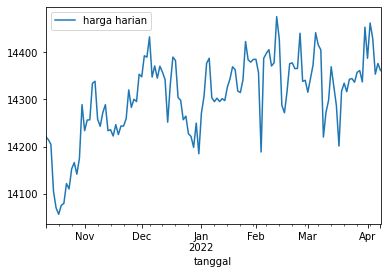

In [13]:
tabelnya.plot()

### Implementing your webscrapping to the flask dashboard

- Copy paste all of your web scrapping process to the desired position on the `app.py`
- Changing the title of the dasboard at `index.html`

## Finishing This Notebook with Your Analysis and Conclusion

First you can do start with making the data visualisation. 

In [ ]:
Analisa grafik
- Harga harian USD-IDR 6 bulan terakhir titik terendahnya terjadi di pertengahan Oktober 2021 
- Harga harian USD-IDR 6 bulan terakhit titik tertingginya terjadi di pertengahan Februari 2022
- Secara overall 6 bulan terakhir harga harian USD-IDR cenderung naik

### Extra Challange

This will be not included to the scoring. 

- You can create additional analysis from the data.
- Implement it to the dashboard with at `app.py` dan `index.html`.